# Kaggle Project: BBC News Classificatation

This project is an attempt at the following competition on Kaggle to classify news articles using raw text: https://www.kaggle.com/competitions/learn-ai-bbc/overview

Importing all necesary libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import re
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

# Step 1: EDA and Raw Text Processing via TF-IDF

## Data Loading and Initial Inspection

First Loading in the test and train data that I took from Kaggle and printing the first few rows.

In [2]:
train_df = pd.read_csv("data2/BBC News Train.csv")
test_df = pd.read_csv("data2/BBC News Test.csv")

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

In [3]:
train_df.head()

,articleid,text,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
test_df.head()

,articleid,text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


Now, just doing a quick inspection of the data to see the shape, size, and seing if we have any null or N/A values

In [5]:
print(train_df.shape, test_df.shape)

(1490, 3) (735, 2)


In [6]:
print('missing train set values:', train_df.isnull().sum())
print('missing test set values:', test_df.isnull().sum())

print('empty strings in train set:', (train_df['text'].str.strip() == '').sum())
print('empty strings in text set:', (test_df['text'].str.strip() == '').sum())

missing train set values: articleid    0
text         0
category     0
dtype: int64
missing test set values: articleid    0
text         0
dtype: int64
empty strings in train set: 0
empty strings in text set: 0


A very simple visualtization to show the article count by category, looks relatively evenly distributed

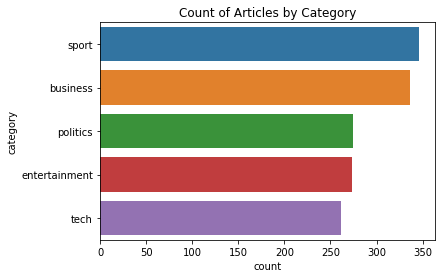

In [7]:
plt.figure()
sns.countplot(y = 'category', data = train_df, order = train_df['category'].value_counts().index)
plt.title('Count of Articles by Category')
plt.show()

Doing some summary statistics to get a feel for the word count in the articles, understand the min/max, avg, etc

In [8]:
print(train_df['text'].apply(lambda x: len(str(x).split())).describe())

count    1490.000000
mean      385.012752
std       210.898616
min        90.000000
25%       253.000000
50%       337.000000
75%       468.750000
max      3345.000000
Name: text, dtype: float64


## Pre-Processing

Now getting into the work of pre-proccessing the data before handing it to TF-IDF. This lowercases all characters, takes out any website/URL links, takes out emails, ensures we are looking at words only.

In [9]:
def normalizer(s):
    return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def preprocess(text):
    if not isinstance(text, str):
        text = str(text)
    text = normalizer(text) #calling normalizer
    text = text.lower() #lowercasing everything
    text = re.compile(r'https?://\S+|www\.\S+').sub(' ', text) #no website references
    text = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b').sub(' ', text) #no emails
    text = re.compile(r'[^a-zA-Z\s]').sub(' ', text) #words only
    text = re.compile(r'\s+').sub(' ', text).strip() #no long spaces

    return text

train_df['proc_text'] = train_df['text'].apply(preprocess)
test_df['proc_text'] = test_df['text'].apply(preprocess)


Checking to see the pre-processing did its job, which it look like it did. As you can see with the text vs proc_tex column, one can see that all dashes are removed, numbers are removed, as well as special characters. Now we have processed text, that is text-only (just words). 

In [10]:
train_df.head()

,articleid,text,category,proc_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex boss launches defence lawyers defe...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in m payout eighteen former enron...


## TF-IDF

I converted all the raw text into matrix form using TF-IDF (Term Frequency- Inverse Document Frecuency). This method essentially takes the text and converts it into a vector of "word weights". It uses the amount of times a word appears (term frequency) to apply weight to words, and also suppresses the weighting of words that appear often across all text (Inverse document frequency). For example, words such as "The", "A", etc.

This gives us a weighted matrix where rows correspond to a document (or article in this case) and and columns represent a term The cell values then show the actual weight in a numerical value, so that we can use this for NMF. 
   

Now, passing the pre-processed data to my TF-IDF vectorizer, then printing a sample of the features and seeing the size of the data

In [11]:
tf_idf = TfidfVectorizer(max_features = 6000, ngram_range = (1,2), stop_words = 'english', min_df = 2)

train_tf_idf = tf_idf.fit_transform(train_df['proc_text'])

test_tf_idf = tf_idf.transform(test_df['proc_text'])

print(train_tf_idf.shape, test_tf_idf.shape)

y = train_df['category'].astype('category')
class_name = list(y.cat.categories)
y_coded = y.cat.codes

(1490, 6000) (735, 6000)


In [12]:
feature_names = tf_idf.get_feature_names()
print('Feature Count', len(feature_names))
print('sample', feature_names[:20])

Feature Count 6000
sample ['abbas', 'abc', 'ability', 'able', 'abroad', 'absence', 'absolute', 'absolutely', 'abuse', 'abused', 'ac', 'ac milan', 'academy', 'academy awards', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'accessible']


## EDA 

Before getting onto the modelling I would like to do some EDA. This first visual is simply showing the top mean 25 terms in the entire dataset

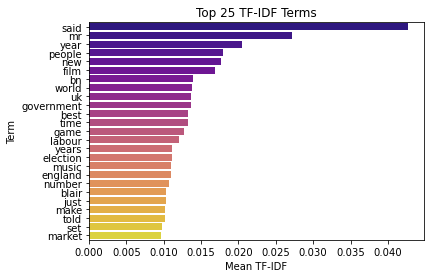

In [13]:
mean_ = np.asarray(train_tf_idf.mean(axis = 0)).ravel()
df_vis = pd.DataFrame({'term': feature_names, 'mean': mean_})
top25 = df_vis.sort_values(by = 'mean', ascending = False).head(25)

plt.figure()

sns.barplot(y = 'term', x = 'mean', data = top25, palette = 'plasma')

plt.title('Top 25 TF-IDF Terms')
plt.xlabel('Mean TF-IDF')
plt.ylabel('Term')
plt.show()

This function and below table gives a top term by category. As one can see, it seems the our TF-IDF did its job correctly because the terms in each category look to match the actual subject matter. For example, one would expect the top terms in sport to be win, team, match, game, england, etc. 

In [14]:
def terms_by_label(tf_idf_matrix, labels, feature_names, top = 10):
    labels = np.asarray(labels)
    feature_names = np.asarray(feature_names)
    
    out_ = {}
    for label in  np.unique(labels):
        mask = (labels == label)

        mean_s = np.asarray(tf_idf_matrix[mask, :].mean(axis = 0)).ravel()
        top_i = mean_s.argsort()[-top:][::-1]
        out_[str(label)] = feature_names[top_i]
    return pd.DataFrame(out_)

df_vis3  = terms_by_label(train_tf_idf, train_df['category'].to_numpy(), feature_names, top = 10)
df_vis3
            

,business,entertainment,politics,sport,tech
0,bn,film,mr,england,people
1,said,best,labour,game,mobile
2,growth,music,said,win,said
3,economy,said,election,said,software
4,market,band,blair,cup,users
5,bank,awards,party,match,technology
6,firm,actor,government,team,microsoft
7,year,award,brown,chelsea,phone
8,company,star,minister,players,net
9,oil,album,mr blair,season,digital


Now creating a heatmap for the top 30 TF-IDF terms to show how they present themselves in each category

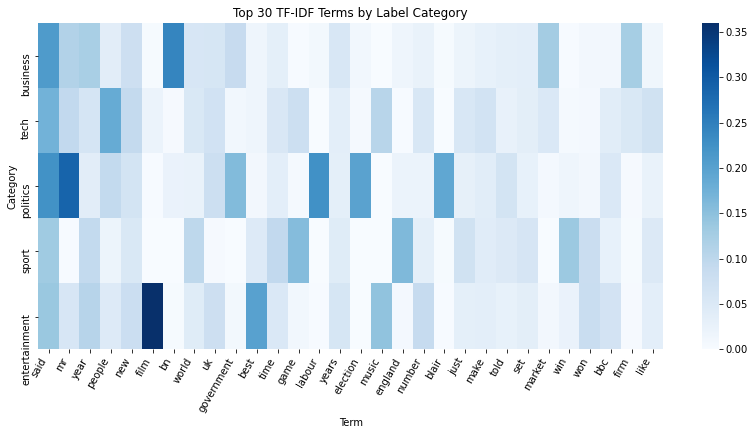

In [15]:
cats = train_df['category'].unique()
means = []

for cat in cats:
    mask = (train_df['category'] == cat).to_numpy()
    cat_mean = np.asarray(train_tf_idf[mask, :].mean(axis= 0)).ravel()
    means.append(cat_mean)

means = np.asarray(means)
means = normalize(means , axis = 1)


large_mean = np.asarray(train_tf_idf.mean(axis = 0)).ravel()
top_i = large_mean.argsort()[-30:][::-1]
top30 = np.array(feature_names)[top_i]

topmeans = means[:, top_i]


plt.figure(figsize = (14, 6))
sns.heatmap(topmeans, cmap = 'Blues', yticklabels = cats, xticklabels= top30)
plt.title('Top 30 TF-IDF Terms by Label Category')
plt.xlabel('Term')
plt.ylabel('Category')

plt.xticks(rotation = 60, ha = 'right')


plt.show()

# Step 2: Building and Training Models

## 1) Conceptual Question

When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

Answer: No, one should not include text from the test dataset in the input matrix when training an unsuprervised model for matrix factorization. This would be considered fitting on the test set and is not the correct approach. It is best to do this for the train set only and not the test set being that it presents data-leakage. 

## 2) Building a a model using the matrix factorization method and predicting the train and test data labels

In terms of hyperparamters to chose for building this model, I chose the number of topics. Because we already have topic lables, I considered this to be a strong way to test my model accuracy- comparing the models generated labels to those that were already given.

Creating NMF Model below

In [16]:
n_topics = 5

nmf = NMF(n_components = n_topics, random_state = 42, max_iter = 300)
W_train = nmf.fit_transform(train_tf_idf)
H = nmf.components_
W_test = nmf.transform(test_tf_idf)

Printing out the top 10 words in each topic to make sure the groupings make logical sense

In [17]:
feature_n = tf_idf.get_feature_names()

n_top_words = 10
for i, topic in enumerate(H):
    top_t = [feature_names[j] for j in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {i}: {', '.join(top_t)}")

Topic 0: england, game, win, wales, ireland, said, cup, team, play, france
Topic 1: mr, labour, blair, election, brown, party, mr blair, said, mr brown, government
Topic 2: mobile, people, music, said, phone, digital, technology, phones, users, broadband
Topic 3: film, best, awards, award, actor, oscar, actress, films, festival, won
Topic 4: bn, growth, said, economy, economic, year, sales, bank, oil, market


Mapping the topics created by my model to the actual topics already labeled in the data to compare accuracy later on

In [18]:
topic_to_label= {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}

train_df['topic'] = W_train.argmax(axis = 1)
train_df['topic'] = train_df['topic'].map(topic_to_label)

## 3) Measuring the performances on predictions from both train and test datasets.

In this code block I am showing the label accuracy by comparing it to the actual labels in the dataset. After this, I created a confusion matrix to show how my NMF perfomed in grouping the articles into category buckets. 

NMF Topic Accuracy: 0.9234899328859061


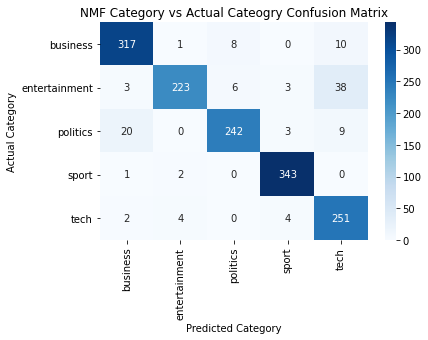

In [19]:
encoder = LabelEncoder()
encoder.fit(train_df['category'])

y_true = encoder.transform(train_df['category'])
y_pred = encoder.transform(train_df['topic'])

acc = accuracy_score(y_true, y_pred)
print(f"NMF Topic Accuracy: {acc}")

cm = confusion_matrix(y_true, y_pred, labels = range(len(encoder.classes_)))
plt.figure()
sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = encoder.classes_, yticklabels = encoder.classes_, 
            cmap = 'Blues')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('NMF Category vs Actual Cateogry Confusion Matrix')

plt.show()

## 4) Changing the hyperparameter and recording the results (i.e. hyperparamter tuning)

For hyperparameter tuning, I decided to use count of componenets (topics) as the hyperparamter I would experiment with. As one can see by the table below, the accuracy peaks at 5 topics. After this, it dips down slightly and then riseds again at 10 topics. This 10 topic count accuracy score is higher than the 5 topic score, but this is likely also due to overfitting. Because of this, I would still chose 5 topics as my desired number to create the highest accuracy without overfitting

,n_components,train_accuracy
0,1,0.232215
1,2,0.402685
2,3,0.604698
3,4,0.749664
4,5,0.923490
5,6,0.902685
6,7,0.877181
7,9,0.907383
8,10,0.934899


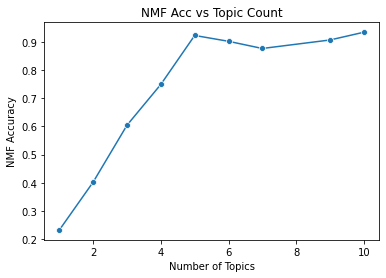

In [20]:
result = []
comp = [1, 2, 3, 4, 5, 6, 7, 9, 10]

for k in comp:
    nmf2 = NMF(n_components = k, random_state = 42, max_iter = 300)
    W_train = nmf2.fit_transform(train_tf_idf)
    topics = W_train.argmax(axis = 1)
    
    nm_df = pd.DataFrame({'topic': topics, 'label': train_df['category']})
    maptotop = nm_df.groupby('topic')['label'].agg(lambda x: x.value_counts().idxmax()).to_dict()
    mapped = nm_df['topic'].map(maptotop)
    
    acc = accuracy_score(train_df['category'], mapped)
    result.append((k, acc))
    
final_df = pd.DataFrame(result, columns = ['n_components', 'train_accuracy'])

display(final_df)

plt.figure()
sns.lineplot(x = 'n_components', y = 'train_accuracy', data = final_df, marker = 'o')
plt.title('NMF Acc vs Topic Count')
plt.xlabel('Number of Topics')
plt.ylabel('NMF Accuracy')
plt.show()

## 5) Improving the Model Performance

To improve model performance, I decided to alter the number of features in my TF-IDF vectorizer. Originally I started at 6000, so I decided to change to 5000 to increase performance. This increased accuracy slightly from 0.923 to 0.924

In [21]:
tfidf_large = TfidfVectorizer(max_features = 5000, ngram_range = (1,2), stop_words = 'english',
                              min_df = 2)

train_tfidf_large = tfidf_large.fit_transform(train_df['proc_text'])
#test_tfidf_large = tf_idf.transform(test_df['proc_text'])

n_topics = 5

nmf_large = NMF(n_components = n_topics, random_state = 42, max_iter = 300)
W_large = nmf_large.fit_transform(train_tfidf_large)
topic_large = W_large.argmax(axis = 1)

nmlarge_df = pd.DataFrame({'topic': topic_large, 'label': train_df['category']})
maplarge = nmlarge_df.groupby('topic')['label'].agg(lambda x: x.value_counts().idxmax()).to_dict()
mappedlarge = nmlarge_df['topic'].map(maplarge)

acc_large = accuracy_score(train_df['category'], mappedlarge)
print('Improved Accuracy with new TF-IDF: ' , acc_large)

Improved Accuracy with new TF-IDF:  0.9241610738255034


# Step 3: Comparing with Supervised Learning

Comparing this unsupervised approach with supervised learning below using Logistic Regression. I am splitting the train set provided 80/20. It should be noted, I am only using the train dataset provided by the kaggle project and then splitting it 80/20 into train and test, because the test set provided by kaggle does not have labels. 

As expected, the supervised learning approach had a higher accuracy. As was already mentioned in the assignment description, supervised learning does best when labels are already provided, and since this data had labels, it performed quite well. As one can see, overfitting is quite small here. We know this because there is a small difference between test-train results. 

Train Accuracy for logistic regression is 0.9966442953020134
Test Accuracy for logistic regression is 0.9731543624161074
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        67
entertainment       0.96      1.00      0.98        55
     politics       0.98      0.96      0.97        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



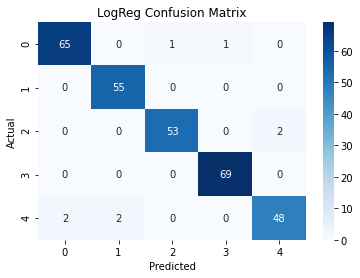

In [22]:
X = train_tf_idf
y = train_df['category'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

logreg = LogisticRegression(max_iter = 500, random_state = 42)
logreg.fit(X_train, y_train)
train_pred = logreg.predict(X_train)
test_pred = logreg.predict(X_test)

print('Train Accuracy for logistic regression is', accuracy_score(y_train, train_pred))
print('Test Accuracy for logistic regression is', accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, test_pred), annot = True, cmap = 'Blues', fmt = 'd')
plt.title('LogReg Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Finally, attmepting different sizes of train sets (10%, 20%, 50%, 80%) to see what yields the best perfromance. In this case, it seems 80% would yield the highest test accuracy, but marginally so compared to the 50% size train set. 

In [23]:
r = []

for frac in [0.1, 0.2, 0.5, 0.8]:
    splt = StratifiedShuffleSplit(n_splits = 1, train_size = frac, random_state = 42)
    (sub_idx, _), = splt.split(X_train, y_train)
    logreg2 = LogisticRegression(max_iter = 500, random_state = 42)
    logreg2.fit(X_train[sub_idx], y_train[sub_idx])
    r.append((frac, logreg2.score(X_test, y_test)))
    
logreg2df = pd.DataFrame(r, columns = ['train_fraction', 'test_accuracy'])
display(logreg2df)

,train_fraction,test_accuracy
0,0.1,0.882550
1,0.2,0.922819
2,0.5,0.956376
3,0.8,0.959732


References: 

1.scikit-learn Developers. (2024). Text feature extraction using TF-IDF. Retrieved from https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction  
2.Wikipedia Contributors. (2025). TF-IDF. In Wikipedia, The Free Encyclopedia. Retrieved from https://en.wikipedia.org/wiki/Tf%E2%80%93idfv  
3.OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)  
4.Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)  
5.Analytics Vidhya. (2021, June 16). Topic modelling using NMF | Guide to master NLP (Part 14). Analytics Vidhya. Retrieved October 27, 2025, from https://www.analyticsvidhya.com/blog/2021/06/part-15-step-by-step-guide-to-master-nlp-topic-modelling-using-nmf/
